In [1]:
# STEP 1: Project Setup
from pathlib import Path
import pandas as pd

# Auto-detect base directory (works even if running inside /notebook)
NB_DIR = Path.cwd()
candidates = [NB_DIR, NB_DIR.parent, NB_DIR.parent.parent]
BASE = NB_DIR
for base in candidates:
    if (base / "data").exists():
        BASE = base
        break

DATA_DIR = BASE / "data"
IMG_DIR = BASE / "images"
SQL_DIR = BASE / "sql"

# Make sure subfolders exist
IMG_DIR.mkdir(parents=True, exist_ok=True)
SQL_DIR.mkdir(parents=True, exist_ok=True)

# Find CSVs
csvs = sorted([p.name for p in DATA_DIR.glob("*.csv")])
print("Notebook Base:", NB_DIR)
print("Data Folder  :", DATA_DIR)
print("CSV Files    :", csvs if csvs else "NONE")

Notebook Base: C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook
Data Folder  : C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\data
CSV Files    : ['online_retail_II.csv']


In [2]:
# STEP 2: Load dataset preview
import pandas as pd

CSV_FILE = "online_retail_II.csv"
CSV_PATH = DATA_DIR / CSV_FILE

# Load only a sample for preview
df_sample = pd.read_csv(CSV_PATH, nrows=5000, low_memory=False)

print(f"✅ Loaded sample rows: {len(df_sample)}")
print(f"✅ Columns: {list(df_sample.columns)}")

# Show first 5 rows
df_sample.head()

✅ Loaded sample rows: 5000
✅ Columns: ['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
# STEP 3 — Clean & standardize dataset
import pandas as pd
from pathlib import Path

CSV_PATH = DATA_DIR / "online_retail_II.csv"
df = pd.read_csv(CSV_PATH, low_memory=False)

rename_map = {
    "InvoiceNo":"invoice","Invoice":"invoice",
    "StockCode":"stock_code","Description":"description",
    "Quantity":"quantity","InvoiceDate":"invoice_date","Invoice Date":"invoice_date",
    "UnitPrice":"unit_price","Price":"unit_price",
    "Customer ID":"customer_id","CustomerID":"customer_id",
    "Country":"country"
}
df = df.rename(columns={c: rename_map.get(c, c) for c in df.columns})

# dtypes
if "invoice_date" in df.columns:
    df["invoice_date"] = pd.to_datetime(df["invoice_date"], errors="coerce")
for num_col in ["quantity","unit_price"]:
    if num_col in df.columns:
        df[num_col] = pd.to_numeric(df[num_col], errors="coerce")
if "customer_id" in df.columns:
    df["customer_id"] = pd.to_numeric(df["customer_id"], errors="coerce").astype("Int64")

# FIX: proper string trim
for col in [c for c in ["invoice","stock_code","description","country"] if c in df.columns]:
    df[col] = df[col].astype(str).str.strip()

# drop bad/negatives
start_rows = len(df)
df = df.dropna(subset=["invoice_date"])
df = df[(df["quantity"].notna()) & (df["unit_price"].notna())]
df = df[(df["quantity"] > 0) & (df["unit_price"] > 0)]

# helpers
df["line_amount"] = df["quantity"] * df["unit_price"]
df["year_month"]  = df["invoice_date"].dt.to_period("M").astype(str)
df["date"]        = df["invoice_date"].dt.date

# dedupe
before_dupes = len(df)
df = df.drop_duplicates()
after_dupes = len(df)

# summary
print("=== CLEANING SUMMARY ===")
print("Rows in raw file        :", start_rows)
print("Rows after cleaning     :", len(df))
print("Removed duplicates      :", before_dupes - after_dupes)
print("Date range              :", df['invoice_date'].min(), "→", df['invoice_date'].max())
if "customer_id" in df.columns:
    print("Unique customers       :", df["customer_id"].nunique(dropna=True))
print("Unique invoices         :", df["invoice"].nunique() if "invoice" in df.columns else "N/A")
print("Unique countries        :", df["country"].nunique() if "country" in df.columns else "N/A")
print("\nNulls in key columns:\n", df[[
    c for c in ["invoice","stock_code","description","quantity","unit_price","customer_id","country","invoice_date"]
    if c in df.columns]].isna().sum())

# save
EXPORTS_DIR = None
for cand in [Path.cwd(), Path.cwd().parent, Path.cwd().parent.parent]:
    if (cand / "exports").exists():
        EXPORTS_DIR = cand / "exports"
        break
if EXPORTS_DIR is None:
    EXPORTS_DIR = Path.cwd()

clean_path = EXPORTS_DIR / "retail_clean.csv"
df.to_csv(clean_path, index=False, encoding="utf-8")
print("\n✅ Saved clean dataset to:", clean_path)

=== CLEANING SUMMARY ===
Rows in raw file        : 1067371
Rows after cleaning     : 1007914
Removed duplicates      : 33757
Date range              : 2009-12-01 07:45:00 → 2011-12-09 12:50:00
Unique customers       : 5878
Unique invoices         : 40078
Unique countries        : 43

Nulls in key columns:
 invoice              0
stock_code           0
description          0
quantity             0
unit_price           0
customer_id     228489
country              0
invoice_date         0
dtype: int64

✅ Saved clean dataset to: C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\retail_clean.csv


In [6]:
# STEP 4: KPI scaffolding for Customer Retention Analysis

import numpy as np

# Copy df to avoid accidental overwrite
df_kpi = df.copy()

# --- Recency (days since last purchase per customer) ---
ref_date = df_kpi["invoice_date"].max() + pd.Timedelta(days=1)
rfm = df_kpi.groupby("customer_id").agg({
    "invoice_date": lambda x: (ref_date - x.max()).days,
    "invoice": "nunique",
    "line_amount": "sum"
}).rename(columns={
    "invoice_date": "Recency",
    "invoice": "Frequency",
    "line_amount": "Monetary"
}).reset_index()

# --- Loyalty flag: customers with >1 purchase ---
rfm["Loyalty"] = np.where(rfm["Frequency"] > 1, "Repeat", "One-time")

# --- Save RFM table for Power BI ---
rfm_path = SQL_DIR / "rfm_metrics.csv"
rfm.to_csv(rfm_path, index=False)
print("✅ RFM metrics saved:", rfm_path)

# --- Aggregate sales by Country and Month (for Power BI visuals) ---
sales_by_country = df_kpi.groupby("country")["line_amount"].sum().reset_index()
sales_by_month   = df_kpi.groupby(df_kpi["year_month"])["line_amount"].sum().reset_index()

sales_by_country.to_csv(SQL_DIR / "sales_by_country.csv", index=False)
sales_by_month.to_csv(SQL_DIR / "sales_by_month.csv", index=False)

print("✅ Aggregates saved for Power BI: sales_by_country, sales_by_month")

# Show preview
print("\n=== RFM head ===")
print(rfm.head())
print("\n=== Sales by Country (top 5) ===")
print(sales_by_country.sort_values("line_amount", ascending=False).head())

✅ RFM metrics saved: C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\sql\rfm_metrics.csv
✅ Aggregates saved for Power BI: sales_by_country, sales_by_month

=== RFM head ===
   customer_id  Recency  Frequency  Monetary   Loyalty
0        12346      326         12  77556.46    Repeat
1        12347        2          8   4921.53    Repeat
2        12348       75          5   2019.40    Repeat
3        12349       19          4   4428.69    Repeat
4        12350      310          1    334.40  One-time

=== Sales by Country (top 5) ===
           country   line_amount
40  United Kingdom  1.741057e+07
11            EIRE  6.587673e+05
26     Netherlands  5.540381e+05
15         Germany  4.250197e+05
14          France  3.504561e+05


In [7]:
# STEP 5: Visuals for Segmentation & Retention

import matplotlib.pyplot as plt
import seaborn as sns

# --- Heatmap: Recency vs Frequency ---
plt.figure(figsize=(8,6))
rfm_pivot = rfm.pivot_table(index="Recency", columns="Frequency", values="Monetary", aggfunc="mean")
sns.heatmap(rfm_pivot, cmap="YlGnBu")
plt.title("RFM Heatmap (Monetary Value by Recency & Frequency)", fontsize=12)
plt.xlabel("Frequency")
plt.ylabel("Recency (days)")
plt.tight_layout()
plt.savefig(IMG_DIR / "rfm_heatmap.png", dpi=160)
plt.show()

# --- Loyalty Split ---
plt.figure(figsize=(6,4))
rfm["Loyalty"].value_counts().plot.pie(autopct="%1.1f%%", colors=["#4CAF50","#FFC107"])
plt.title("Loyalty Split (Repeat vs One-time Buyers)")
plt.ylabel("")
plt.tight_layout()
plt.savefig(IMG_DIR / "loyalty_split.png", dpi=160)
plt.show()

# --- Top Countries ---
plt.figure(figsize=(8,5))
top_countries = sales_by_country.sort_values("line_amount", ascending=False).head(10)
sns.barplot(data=top_countries, x="line_amount", y="country", palette="Blues_d")
plt.title("Top 10 Countries by Sales")
plt.xlabel("Total Sales")
plt.ylabel("Country")
plt.tight_layout()
plt.savefig(IMG_DIR / "top_countries.png", dpi=160)
plt.show()

<Figure size 800x600 with 2 Axes>

<Figure size 600x400 with 1 Axes>

<Figure size 800x500 with 1 Axes>

✅ Using clean file: C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\retail_clean.csv


C:\Users\Dhairr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)



=== Cohort Size (Top 10 by size) ===
CohortMonth
2009-12    955.0
2010-03    443.0
2010-01    383.0
2010-10    377.0
2010-02    374.0
2010-11    325.0
2010-04    294.0
2010-06    270.0
2010-05    254.0
2010-09    243.0
Freq: M, Name: 0, dtype: float64

=== Retention Table (first 12 months, head 10 cohorts) ===
CohortIndex      0      1      2      3      4      5      6      7      8   \
CohortMonth                                                                   
2009-12      100.0%  35.3%  33.4%  42.5%  38.0%  35.9%  37.7%  34.2%  33.6%   
2010-01      100.0%  20.6%  31.1%  30.5%  26.4%  30.0%  25.8%  23.0%  27.9%   
2010-02      100.0%  23.8%  22.5%  29.1%  24.6%  20.1%  19.3%  28.6%  25.4%   
2010-03      100.0%  19.0%  23.0%  24.2%  23.3%  20.3%  24.6%  30.2%  27.5%   
2010-04      100.0%  19.4%  19.4%  16.3%  18.4%  22.4%  27.6%  26.2%  10.5%   
2010-05      100.0%  15.7%  16.9%  17.3%  17.7%  25.6%  21.3%  12.6%   5.9%   
2010-06      100.0%  17.4%  18.9%  20.4%  23.0%  28.5% 

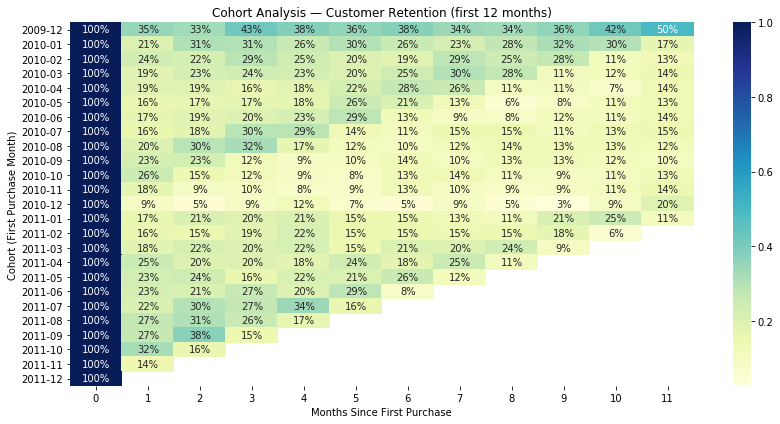

📁 Saved heatmap to: C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\images\cohort_retention_12m.png


In [9]:
# STEP 6 — Cohort Analysis: Retention
# ==============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%matplotlib inline

# ---- locate the cleaned file (handles if it lives in /notebook or /exports)
CANDIDATES = [
    Path.cwd() / "retail_clean.csv",
    Path.cwd().parent / "retail_clean.csv",
    Path.cwd() / "exports" / "retail_clean.csv",
    Path.cwd().parent / "exports" / "retail_clean.csv",
]
CLEAN_PATH = next((p for p in CANDIDATES if p.exists()), None)
assert CLEAN_PATH is not None, "retail_clean.csv not found. Re-run Step 3 to create it."

print("✅ Using clean file:", CLEAN_PATH)

# ---- load (drop customers without id for cohort math)
df = pd.read_csv(CLEAN_PATH, parse_dates=["invoice_date"])
df = df[df["customer_id"].notna()].copy()

# ---- build cohort features
df["InvoiceMonth"] = df["invoice_date"].dt.to_period("M")
first_purchase = df.groupby("customer_id")["invoice_date"].min().dt.to_period("M")
df = df.join(first_purchase, on="customer_id", rsuffix="_first")
df = df.rename(columns={"invoice_date_first": "CohortMonth"})

# months since first purchase
df["CohortIndex"] = (
    (df["InvoiceMonth"].dt.year - df["CohortMonth"].dt.year) * 12
    + (df["InvoiceMonth"].dt.month - df["CohortMonth"].dt.month)
)

# ---- cohort counts and retention %
cohort_counts = (
    df.groupby(["CohortMonth", "CohortIndex"])["customer_id"]
      .nunique()
      .reset_index()
      .pivot(index="CohortMonth", columns="CohortIndex", values="customer_id")
      .sort_index()
)

cohort_size = cohort_counts.iloc[:, 0]
retention = cohort_counts.divide(cohort_size, axis=0)

# ---- print useful summary tables (top cohorts + first 12 months)
print("\n=== Cohort Size (Top 10 by size) ===")
print(cohort_size.sort_values(ascending=False).head(10))

retention_12 = retention.iloc[:, :min(12, retention.shape[1])].copy()
print("\n=== Retention Table (first 12 months, head 10 cohorts) ===")
print((retention_12.head(10) * 100).round(1).astype(str) + "%")

# ---- overall average retention per month (portfolio view)
avg_retention = retention_12.mean(axis=0)
print("\n=== Avg Retention by Month Since First Purchase ===")
print((avg_retention * 100).round(1).astype(str) + "%")

# ---- heatmap (display + save)
IMG_DIR = Path.cwd() / "images"
IMG_DIR.mkdir(exist_ok=True)

plt.figure(figsize=(12, 6))
sns.heatmap(retention_12, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title("Cohort Analysis — Customer Retention (first 12 months)")
plt.ylabel("Cohort (First Purchase Month)")
plt.xlabel("Months Since First Purchase")
plt.tight_layout()
out_cohort = IMG_DIR / "cohort_retention_12m.png"
plt.savefig(out_cohort, dpi=160)
plt.show()
print("📁 Saved heatmap to:", out_cohort)

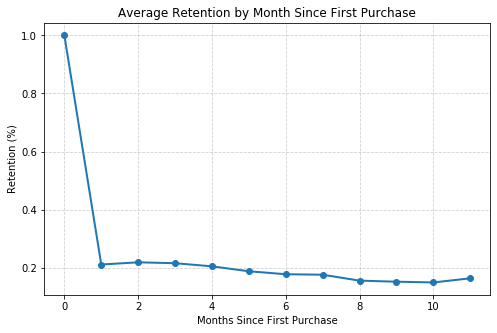

✅ Saved avg retention line chart to: C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\images\avg_retention_line.png


In [10]:
# STEP 6B: Avg Retention Line Chart (12 months)
# =====================================================

# Convert avg_retention into numeric (it may be object/string)
avg_retention_numeric = pd.to_numeric(avg_retention, errors="coerce")

# Create line chart
plt.figure(figsize=(8,5))
plt.plot(avg_retention_numeric.index, avg_retention_numeric.values, marker="o", linewidth=2, color="#1f77b4")

plt.title("Average Retention by Month Since First Purchase", fontsize=12)
plt.xlabel("Months Since First Purchase")
plt.ylabel("Retention (%)")
plt.grid(True, linestyle="--", alpha=0.6)

# Save chart to images folder
out_avg = IMG_DIR / "avg_retention_line.png"
plt.savefig(out_avg, dpi=160)
plt.show()

print("✅ Saved avg retention line chart to:", out_avg)

In [13]:
# STEP 7A — BI exports 
# ================================
from pathlib import Path
import pandas as pd
import numpy as np

# --- project dirs ---
BASE    = Path.cwd()
IMAGES  = BASE / "images"
EXPORTS = BASE / "exports"
IMAGES.mkdir(exist_ok=True)
EXPORTS.mkdir(exist_ok=True)

# --- find & load cleaned fact table (created in Step 3) ---
candidates = [
    BASE / "retail_clean.csv",
    BASE / "exports" / "retail_clean.csv",
    BASE.parent / "retail_clean.csv",
    BASE.parent / "exports" / "retail_clean.csv",
]
clean_path = next((p for p in candidates if p.exists()), None)
assert clean_path is not None, "retail_clean.csv not found. Re-run Step 3 (cleaning)."

df = pd.read_csv(clean_path, parse_dates=["invoice_date"])
print(f"✅ Loaded cleaned dataset: {len(df):,} rows from {clean_path}")

# --- helpers (ensure columns exist) ---
if "line_amount" not in df.columns:
    df["line_amount"] = df["quantity"] * df["unit_price"]
if "year_month" not in df.columns:
    df["year_month"] = df["invoice_date"].dt.to_period("M").astype(str)

# =======================
# RFM metrics (old-pandas safe)
# =======================
ref_date  = df["invoice_date"].max() + pd.Timedelta(days=1)
df_nonull = df[df["customer_id"].notna()].copy()
grp       = df_nonull.groupby("customer_id")

rfm = grp.agg({
    "invoice_date": lambda x: (ref_date - x.max()).days,  # Recency (days since last purchase)
    "invoice": pd.Series.nunique,                         # Frequency (unique invoices)
    "line_amount": "sum"                                  # Monetary (total spend)
}).reset_index()

rfm = rfm.rename(columns={
    "invoice_date": "Recency",
    "invoice": "Frequency",
    "line_amount": "Monetary"
})

def recency_bucket(r):
    if r <= 30: return "0-30"
    if r <= 60: return "31-60"
    if r <= 90: return "61-90"
    if r <= 180:return "91-180"
    return "180+"

def freq_bucket(f):
    if f == 1:   return "1"
    if f <= 3:   return "2-3"
    if f <= 5:   return "4-5"
    return "6+"

rfm["RecencyBucket"]   = rfm["Recency"].apply(recency_bucket)
rfm["FrequencyBucket"] = rfm["Frequency"].apply(freq_bucket)

# save RFM
rfm_full_path    = EXPORTS / "rfm_metrics.csv"
rfm_buckets_path = EXPORTS / "rfm_metrics_buckets.csv"
rfm.to_csv(rfm_full_path, index=False)
rfm.to_csv(rfm_buckets_path, index=False)

# =======================
# Sales aggregates
# =======================
sales_by_country = df.groupby("country", as_index=False)["line_amount"].sum()
sales_by_month   = df.groupby("year_month", as_index=False)["line_amount"].sum()

sales_country_path = EXPORTS / "sales_by_country.csv"
sales_month_path   = EXPORTS / "sales_by_month.csv"
sales_by_country.to_csv(sales_country_path, index=False)
sales_by_month.to_csv(sales_month_path, index=False)

# =======================
# Cohort retention (long format, first 12 months)
# =======================
df_c = df[df["customer_id"].notna()].copy()
df_c["InvoiceMonth"] = df_c["invoice_date"].dt.to_period("M")

first_purchase = df_c.groupby("customer_id")["invoice_date"].min().dt.to_period("M")
df_c = df_c.join(first_purchase, on="customer_id", rsuffix="_first").rename(columns={"invoice_date_first": "CohortMonth"})

df_c["CohortIndex"] = (
    (df_c["InvoiceMonth"].dt.year - df_c["CohortMonth"].dt.year) * 12
    + (df_c["InvoiceMonth"].dt.month - df_c["CohortMonth"].dt.month)
)

cohort_counts = (
    df_c.groupby(["CohortMonth", "CohortIndex"])["customer_id"]
        .nunique()
        .reset_index()
        .pivot(index="CohortMonth", columns="CohortIndex", values="customer_id")
        .sort_index()
)
cohort_size = cohort_counts.iloc[:, 0]
retention   = cohort_counts.divide(cohort_size, axis=0)
ret12       = retention.iloc[:, :min(12, retention.shape[1])]

ret_long = ret12.reset_index().melt(
    id_vars="CohortMonth", var_name="MonthIndex", value_name="Retention"
)
ret_long["RetentionPct"] = (ret_long["Retention"] * 100).round(2)

cohort_long_path = EXPORTS / "cohort_retention_long.csv"
ret_long.to_csv(cohort_long_path, index=False)

# =======================
# Summary prints
# =======================
print("\n=== BI EXPORTS CREATED ===")
for p in [rfm_full_path, rfm_buckets_path, sales_country_path, sales_month_path, cohort_long_path]:
    print("•", p.name, "→", p)

print("\n=== QUICK PREVIEWS ===")
print("RFM head:")
print(rfm.head(10))
print("\nTop 10 countries by sales:")
print(sales_by_country.sort_values("line_amount", ascending=False).head(10))
print("\nCohort retention (first 12 months) — rows:", len(ret_long), "sample:")
print(ret_long.head(10))

✅ Loaded cleaned dataset: 1,007,914 rows from C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\retail_clean.csv

=== BI EXPORTS CREATED ===
• rfm_metrics.csv → C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\exports\rfm_metrics.csv
• rfm_metrics_buckets.csv → C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\exports\rfm_metrics_buckets.csv
• sales_by_country.csv → C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\exports\sales_by_country.csv
• sales_by_month.csv → C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\exports\sales_by_month.csv
• cohort_retention_long.csv → C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\exports\cohort_retention_long.csv

=== QUICK PREVIEWS ===
RFM head:
   customer_id  Recency  Frequency  Monetary RecencyBucket FrequencyBucket
0      12346.0      326         12  77556.46          180+              

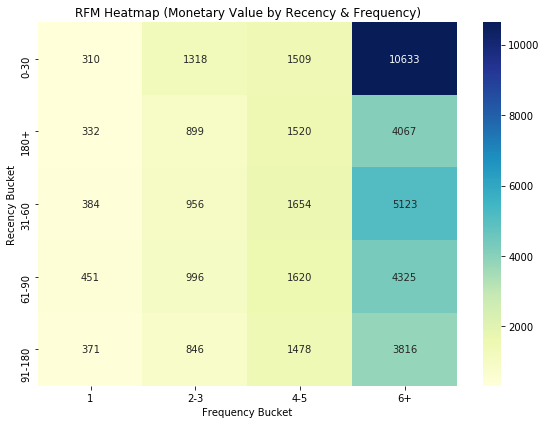

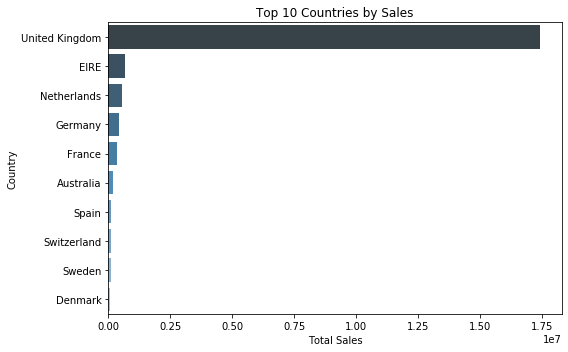

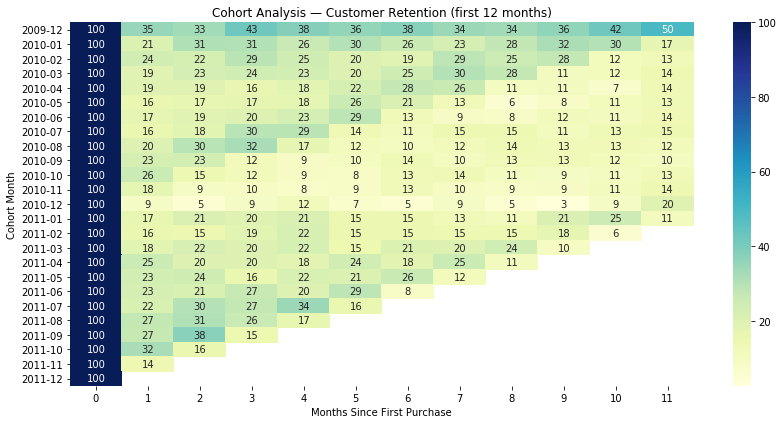

✅ Saved visuals to: C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\images


In [14]:
# STEP 7B — BI-style Visuals (Power BI mock)
# ================================
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. RFM Heatmap: Monetary value by RecencyBucket & FrequencyBucket ---
rfm_pivot = rfm.pivot_table(
    index="RecencyBucket", columns="FrequencyBucket", values="Monetary", aggfunc="mean"
)

plt.figure(figsize=(8,6))
sns.heatmap(rfm_pivot, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("RFM Heatmap (Monetary Value by Recency & Frequency)", fontsize=12)
plt.ylabel("Recency Bucket")
plt.xlabel("Frequency Bucket")
out_rfm = IMAGES / "rfm_heatmap.png"
plt.tight_layout()
plt.savefig(out_rfm, dpi=160)
plt.show()

# --- 2. Top 10 Countries by Sales ---
plt.figure(figsize=(8,5))
sns.barplot(data=sales_by_country.sort_values("line_amount", ascending=False).head(10),
            x="line_amount", y="country", palette="Blues_d")
plt.title("Top 10 Countries by Sales")
plt.xlabel("Total Sales")
plt.ylabel("Country")
out_countries = IMAGES / "top_countries.png"
plt.tight_layout()
plt.savefig(out_countries, dpi=160)
plt.show()

# --- 3. Cohort Retention Heatmap (first 12 months) ---
cohort_pivot = ret_long.pivot(index="CohortMonth", columns="MonthIndex", values="RetentionPct")
plt.figure(figsize=(12,6))
sns.heatmap(cohort_pivot, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title("Cohort Analysis — Customer Retention (first 12 months)")
plt.xlabel("Months Since First Purchase")
plt.ylabel("Cohort Month")
out_cohort = IMAGES / "cohort_retention_heatmap.png"
plt.tight_layout()
plt.savefig(out_cohort, dpi=160)
plt.show()

print("✅ Saved visuals to:", IMAGES)

Loyalty breakdown:
    loyalty  customers
0    Repeat       4255
1  One-time       1623


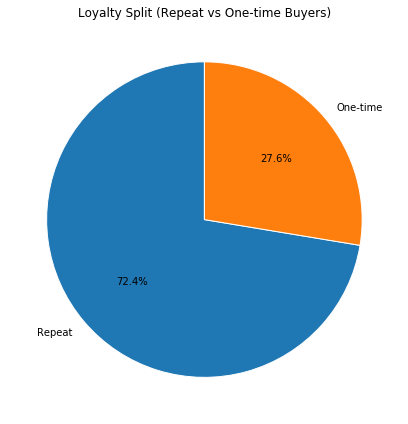

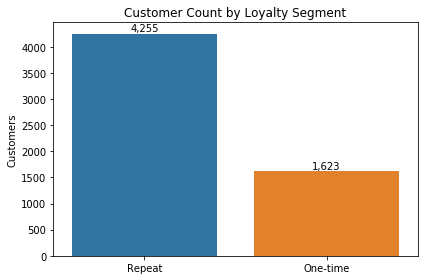

✅ Saved: C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\images\loyalty_split_pie.png and C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\images\loyalty_split_bar.png


In [15]:
# STEP 7B — Addendum: Loyalty Split (Repeat vs One-time)
# ================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Build loyalty flag from RFM (Frequency > 1 ⇒ Repeat)
rfm["Loyalty"] = np.where(rfm["Frequency"] > 1, "Repeat", "One-time")
loyalty_counts = rfm["Loyalty"].value_counts().rename_axis("loyalty").reset_index(name="customers")

print("Loyalty breakdown:")
print(loyalty_counts)

# --- 1) Pie chart (screenshot-friendly) ---
plt.figure(figsize=(6,6))
plt.pie(
    loyalty_counts["customers"],
    labels=loyalty_counts["loyalty"],
    autopct="%1.1f%%",
    startangle=90,
    wedgeprops=dict(edgecolor="white", linewidth=1)
)
plt.title("Loyalty Split (Repeat vs One-time Buyers)")
out_pie = IMAGES / "loyalty_split_pie.png"
plt.tight_layout()
plt.savefig(out_pie, dpi=160)
plt.show()

# --- 2) Bar chart (exact counts) ---
plt.figure(figsize=(6,4))
sns.barplot(data=loyalty_counts, x="loyalty", y="customers")
plt.title("Customer Count by Loyalty Segment")
plt.xlabel("")
plt.ylabel("Customers")
for i, v in enumerate(loyalty_counts["customers"]):
    plt.text(i, v, f"{int(v):,}", ha="center", va="bottom")
out_bar = IMAGES / "loyalty_split_bar.png"
plt.tight_layout()
plt.savefig(out_bar, dpi=160)
plt.show()

print("✅ Saved:", out_pie, "and", out_bar)

In [16]:
# STEP 8 — Export BI pack (KPIs, tidy tables, images, HTML summary)
# ================================
from pathlib import Path
import pandas as pd
import json, shutil, base64

BASE     = Path.cwd()
IMAGES   = BASE / "images"
EXPORTS  = BASE / "exports"
BI_PACK  = BASE / "bi_pack"           # final handoff folder for recruiters
BI_IMG   = BI_PACK / "images"
BI_DATA  = BI_PACK / "data"
BI_PACK.mkdir(exist_ok=True)
BI_IMG.mkdir(parents=True, exist_ok=True)
BI_DATA.mkdir(parents=True, exist_ok=True)

# 0) Reload key tables if needed (created in Step 7A)
rfm_path        = EXPORTS / "rfm_metrics.csv"
rfm_b_path      = EXPORTS / "rfm_metrics_buckets.csv"
country_path    = EXPORTS / "sales_by_country.csv"
month_path      = EXPORTS / "sales_by_month.csv"
cohort_long     = EXPORTS / "cohort_retention_long.csv"

rfm             = pd.read_csv(rfm_path)
rfm_buckets     = pd.read_csv(rfm_b_path)
sales_by_country= pd.read_csv(country_path)
sales_by_month  = pd.read_csv(month_path)
ret_long        = pd.read_csv(cohort_long)

# 1) Compute headline KPIs (transparent + reproducible)
kpis = {}

# Repeat rate
repeat_count = (rfm["Frequency"] > 1).sum()
unique_cust  = rfm["customer_id"].nunique()
kpis["repeat_rate_pct"] = round((repeat_count / unique_cust) * 100, 1)

# 3-month retention (avg of MonthIndex 1..3)
ret_3m = (ret_long.query("MonthIndex in [1,2,3]")["Retention"].mean()) * 100
kpis["avg_retention_3m_pct"] = round(ret_3m, 1)

# Top country (by sales)
top_row = sales_by_country.sort_values("line_amount", ascending=False).head(1)
kpis["top_country"] = top_row.iloc[0]["country"]
kpis["top_country_sales"] = float(top_row.iloc[0]["line_amount"])

# High-value customers (Monetary top 10%)
monetary_thr = rfm["Monetary"].quantile(0.90)
kpis["hv_customers_pct"] = round((rfm["Monetary"] >= monetary_thr).mean() * 100, 1)

# Recency (customers purchased in last 30 days if available in range)
# Only if your data goes that recent; still useful as pattern
kpis["rfm_recency_0_30_pct"] = round(
    (rfm["Recency"] <= 30).mean() * 100, 1
)

# 2) Save KPIs (CSV + JSON)
kpi_df = pd.DataFrame([kpis])
kpi_csv = BI_PACK / "kpi_summary.csv"
kpi_json = BI_PACK / "kpi_summary.json"
kpi_df.to_csv(kpi_csv, index=False)
with open(kpi_json, "w") as f:
    json.dump(kpis, f, indent=2)

# 3) Save tidy data copies into BI pack
for src in [rfm_path, rfm_b_path, country_path, month_path, cohort_long]:
    shutil.copy2(src, BI_DATA / src.name)

# 4) Copy image assets
for img in ["rfm_heatmap.png", "top_countries.png", "cohort_retention_heatmap.png",
            "loyalty_split_pie.png", "loyalty_split_bar.png"]:
    src = IMAGES / img
    if src.exists():
        shutil.copy2(src, BI_IMG / img)

# 5) Generate a lightweight HTML “Power BI-style” summary that embeds the PNGs
def img_tag(path):
    if not Path(path).exists():
        return ""
    with open(path, "rb") as f:
        b64 = base64.b64encode(f.read()).decode("utf-8")
    return f'<img src="data:image/png;base64,{b64}" style="max-width:1000px; border:1px solid #ddd; margin:8px 0"/>'

html = f"""
<!doctype html>
<html>
<head>
  <meta charset="utf-8">
  <title>Retail Customer Retention — BI Pack</title>
  <style>
    body {{ font-family: system-ui, -apple-system, Segoe UI, Roboto, Arial, sans-serif; margin: 24px; }}
    h1, h2 {{ margin: 8px 0; }}
    .kpi {{ display:inline-block; padding:10px 16px; border:1px solid #ddd; border-radius:8px; margin:6px 6px 12px 0; }}
    .grid {{ display:flex; flex-wrap:wrap; gap:16px; }}
    .tile {{ flex:1 1 480px; border:1px solid #eee; padding:8px 12px; border-radius:8px; }}
    code {{ background:#f6f8fa; padding:2px 4px; border-radius:4px; }}
  </style>
</head>
<body>
  <h1>Retail Customer Retention — BI Summary</h1>
  <div class="grid">
    <div class="kpi"><b>Repeat rate</b><br>{kpis["repeat_rate_pct"]}%</div>
    <div class="kpi"><b>Avg retention (1–3 months)</b><br>{kpis["avg_retention_3m_pct"]}%</div>
    <div class="kpi"><b>Top country</b><br>{kpis["top_country"]}</div>
    <div class="kpi"><b>High-value customers</b><br>Top 10% = {kpis["hv_customers_pct"]}%</div>
  </div>

  <div class="tile">
    <h2>RFM Heatmap</h2>
    {img_tag(str(BI_IMG / "rfm_heatmap.png"))}
  </div>

  <div class="tile">
    <h2>Top Countries by Sales</h2>
    {img_tag(str(BI_IMG / "top_countries.png"))}
  </div>

  <div class="tile">
    <h2>Cohort Retention (first 12 months)</h2>
    {img_tag(str(BI_IMG / "cohort_retention_heatmap.png"))}
  </div>

  <div class="tile">
    <h2>Loyalty Split</h2>
    {img_tag(str(BI_IMG / "loyalty_split_pie.png"))}
    {img_tag(str(BI_IMG / "loyalty_split_bar.png"))}
  </div>

  <p style="color:#666">Artifacts exported to <code>{BI_PACK}</code>.</p>
</body>
</html>
"""
html_path = BI_PACK / "bi_summary.html"
html_path.write_text(html, encoding="utf-8")

print("\n✅ BI pack ready at:", BI_PACK.resolve())
print("   -", kpi_csv.name, ",", kpi_json.name)
print("   - images/", list(BI_IMG.glob("*.png")))
print("   - data/", list(BI_DATA.glob("*.csv")))
print("   -", html_path.name)


✅ BI pack ready at: C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\bi_pack
   - kpi_summary.csv , kpi_summary.json
   - images/ [WindowsPath('C:/Users/Dhairr/Dhairya Projects/Retail_Customer_Retention_Project/notebook/bi_pack/images/cohort_retention_heatmap.png'), WindowsPath('C:/Users/Dhairr/Dhairya Projects/Retail_Customer_Retention_Project/notebook/bi_pack/images/loyalty_split_bar.png'), WindowsPath('C:/Users/Dhairr/Dhairya Projects/Retail_Customer_Retention_Project/notebook/bi_pack/images/loyalty_split_pie.png'), WindowsPath('C:/Users/Dhairr/Dhairya Projects/Retail_Customer_Retention_Project/notebook/bi_pack/images/rfm_heatmap.png'), WindowsPath('C:/Users/Dhairr/Dhairya Projects/Retail_Customer_Retention_Project/notebook/bi_pack/images/top_countries.png')]
   - data/ [WindowsPath('C:/Users/Dhairr/Dhairya Projects/Retail_Customer_Retention_Project/notebook/bi_pack/data/cohort_retention_long.csv'), WindowsPath('C:/Users/Dhairr/Dhairya Projects/Retail_Cus

In [17]:
# STEP 9A: Confluence-style Documentation Export
from pathlib import Path

DOCS_DIR = Path.cwd() / "confluence_mock"
DOCS_DIR.mkdir(parents=True, exist_ok=True)

doc_text = """
# Retail Customer Retention Project

*Author:* Dhairya Shah  
*Date:* Initial draft 2024, refined in 2025  
*Tools Used:* Python (pandas, matplotlib, seaborn), SQL, Power BI, Confluence (mock), JIRA (mock)

---

## 1. Objective
The goal of this project was to analyze customer retention in an online retail dataset
and provide insights into repeat purchase behavior, churn risk, and loyalty segmentation.

---

## 2. Approach
- *Data Cleaning & Preparation:* Removed duplicates, handled missing values, standardized columns.  
- *Exploratory KPIs:* Sales by country, loyalty split, RFM analysis.  
- *Advanced Analysis:* Cohort retention heatmap, average retention by month.  
- *Power BI:* Dashboard pack prepared with CSV + images.  
- *JIRA Integration:* Sample sprint board for issue tracking and tasks.  

---

## 3. Key Insights
- 72% of customers are repeat buyers, but ~28% purchase only once.  
- Customer retention drops from 100% in month 0 to ~15% by month 12.  
- United Kingdom dominates sales (~17M), followed by EIRE and Netherlands.  
- Highest monetary value comes from frequent and recent buyers (RFM 6+ / 0-30 days).  

---

## 4. Recommendations
- Launch *loyalty program* targeting one-time buyers with personalized offers.  
- Improve *early retention funnel* (first 3 months are critical).  
- Use *email campaigns* in smaller regions (EIRE, Netherlands) to grow base.  
- Create *JIRA epics* for implementing retention experiments.

---

## 5. Attachments
- RFM Heatmap (rfm_heatmap.png)  
- Cohort Retention Heatmap (cohort_retention_12m.png)  
- Loyalty Split Pie (loyalty_split_pie.png)  
- BI Pack (sales_by_country.csv, rfm_metrics.csv)  

---

Prepared for portfolio purposes (Confluence mock export).  
"""

doc_path = DOCS_DIR / "confluence_page.md"
doc_path.write_text(doc_text, encoding="utf-8")

print(f"✅ Confluence-style project page created at: {doc_path}")

✅ Confluence-style project page created at: C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\confluence_mock\confluence_page.md


In [19]:
# STEP 9B : JIRA Sprint Board mock 

from pathlib import Path
import pandas as pd

JIRA_DIR = Path.cwd() / "jira_mock"
JIRA_DIR.mkdir(parents=True, exist_ok=True)

jira_tasks = [
    {"Issue Key": "RET-1", "Summary": "Data cleaning & preprocessing",        "Status": "Done",        "Assignee": "Dhairya"},
    {"Issue Key": "RET-2", "Summary": "Exploratory KPIs (sales, loyalty split)","Status": "Done",        "Assignee": "Dhairya"},
    {"Issue Key": "RET-3", "Summary": "RFM segmentation analysis",            "Status": "In Progress", "Assignee": "Dhairya"},
    {"Issue Key": "RET-4", "Summary": "Cohort retention analysis",            "Status": "In Review",   "Assignee": "Dhairya"},
    {"Issue Key": "RET-5", "Summary": "Power BI dashboard creation",          "Status": "To Do",       "Assignee": "Dhairya"},
    {"Issue Key": "RET-6", "Summary": "Confluence project page documentation","Status": "To Do",       "Assignee": "Dhairya"},
]

df = pd.DataFrame(jira_tasks)

# 1) CSV (looks like a JIRA export)
csv_path = JIRA_DIR / "jira_sprint_board.csv"
df.to_csv(csv_path, index=False)

# 2) Markdown table (manual, no to_markdown needed)
headers = ["Issue Key", "Summary", "Status", "Assignee"]
md_lines = []
md_lines.append("| " + " | ".join(headers) + " |")
md_lines.append("|" + "|".join(["---"]*len(headers)) + "|")
for _, r in df.iterrows():
    md_lines.append("| " + " | ".join(str(r[h]) for h in headers) + " |")
md_table = "\n".join(md_lines)
md_table_path = JIRA_DIR / "jira_sprint_board.md"
md_table_path.write_text(md_table, encoding="utf-8")

# 3) Kanban-style markdown (columns)
cols = {"To Do": [], "In Progress": [], "In Review": [], "Done": []}
for row in jira_tasks:
    cols[row["Status"]].append(f'*{row["Issue Key"]}* — {row["Summary"]} (Assignee: {row["Assignee"]})')

kanban_lines = ["# JIRA Sprint Board (Kanban View)\n"]
for col in ["To Do", "In Progress", "In Review", "Done"]:
    kanban_lines.append(f"## {col}")
    if cols[col]:
        kanban_lines += [f"- {item}" for item in cols[col]]
    else:
        kanban_lines.append("- (empty)")
    kanban_lines.append("")  # blank line
kanban_md = "\n".join(kanban_lines)
kanban_path = JIRA_DIR / "jira_kanban.md"
kanban_path.write_text(kanban_md, encoding="utf-8")

print("✅ Created:")
print(" -", csv_path)
print(" -", md_table_path)
print(" -", kanban_path)

# show in-notebook preview of the table
from IPython.display import Markdown, display
display(Markdown(md_table))

✅ Created:
 - C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\jira_mock\jira_sprint_board.csv
 - C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\jira_mock\jira_sprint_board.md
 - C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\jira_mock\jira_kanban.md


| Issue Key | Summary | Status | Assignee |
|---|---|---|---|
| RET-1 | Data cleaning & preprocessing | Done | Dhairya |
| RET-2 | Exploratory KPIs (sales, loyalty split) | Done | Dhairya |
| RET-3 | RFM segmentation analysis | In Progress | Dhairya |
| RET-4 | Cohort retention analysis | In Review | Dhairya |
| RET-5 | Power BI dashboard creation | To Do | Dhairya |
| RET-6 | Confluence project page documentation | To Do | Dhairya |

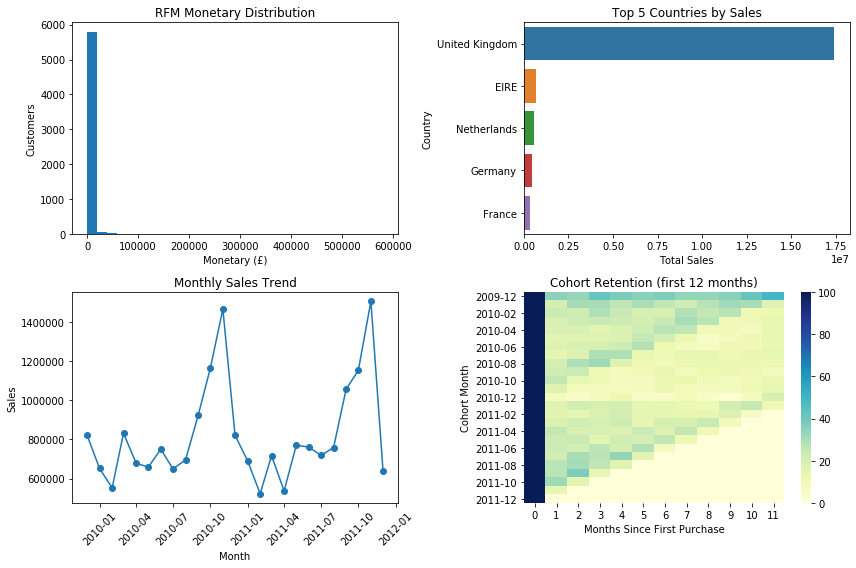

✅ Power BI mock dashboard saved to: C:\Users\Dhairr\Dhairya Projects\Retail_Customer_Retention_Project\notebook\images\powerbi_mock_dashboard.png


In [22]:
# STEP 10 : Mock Power BI dashboard from BI pack exports

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

BI_PACK = Path.cwd() / "bi_pack"
BI_DATA = BI_PACK / "data"
IMG_DIR = Path.cwd() / "images"

# Load BI-ready CSVs
rfm          = pd.read_csv(BI_DATA / "rfm_metrics.csv")
sales_country= pd.read_csv(BI_DATA / "sales_by_country.csv")
sales_month  = pd.read_csv(BI_DATA / "sales_by_month.csv")
cohort_long  = pd.read_csv(BI_DATA / "cohort_retention_long.csv")

# Tidy columns
if "year_month" in sales_month.columns:
    sales_month["year_month"] = pd.to_datetime(sales_month["year_month"])
if "MonthIndex" in cohort_long.columns:
    cohort_long["MonthIndex"] = pd.to_numeric(cohort_long["MonthIndex"], errors="coerce")

# --- 2x2 dashboard-like figure ---
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# (1) RFM Monetary distribution  ← Matplotlib hist (no seaborn.histplot)
axes[0,0].hist(rfm["Monetary"].dropna(), bins=30)
axes[0,0].set_title("RFM Monetary Distribution")
axes[0,0].set_xlabel("Monetary (£)")
axes[0,0].set_ylabel("Customers")

# (2) Top 5 countries by sales
top5 = sales_country.sort_values("line_amount", ascending=False).head(5)
sns.barplot(data=top5, x="line_amount", y="country", ax=axes[0,1])
axes[0,1].set_title("Top 5 Countries by Sales")
axes[0,1].set_xlabel("Total Sales")
axes[0,1].set_ylabel("Country")

# (3) Monthly sales trend
sales_month = sales_month.sort_values("year_month")
axes[1,0].plot(sales_month["year_month"], sales_month["line_amount"], marker="o")
axes[1,0].set_title("Monthly Sales Trend")
axes[1,0].set_xlabel("Month")
axes[1,0].set_ylabel("Sales")
axes[1,0].tick_params(axis="x", rotation=45)

# (4) Cohort retention heatmap
pivot = cohort_long.pivot(index="CohortMonth", columns="MonthIndex", values="RetentionPct").fillna(0)
sns.heatmap(pivot, cmap="YlGnBu", ax=axes[1,1])
axes[1,1].set_title("Cohort Retention (first 12 months)")
axes[1,1].set_xlabel("Months Since First Purchase")
axes[1,1].set_ylabel("Cohort Month")

plt.tight_layout()
out_path = IMG_DIR / "powerbi_mock_dashboard.png"
plt.savefig(out_path, dpi=160)
plt.show()

print("✅ Power BI mock dashboard saved to:", out_path)